In [16]:
import pandas as pd
import numpy as np

import pymc3 as pm
import theano.tensor as tt
import arviz as az

import torch

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from tqdm import tqdm

In [17]:
data = pd.read_csv('../data/winequality-red.csv')
data = (data-data.mean())/data.std()
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946,-0.787576
1,-0.298454,1.966827,-1.391037,0.043403,0.223805,0.872365,0.624168,0.028252,-0.719708,0.128910,-0.584594,-0.787576
2,-0.298454,1.296660,-1.185699,-0.169374,0.096323,-0.083643,0.228975,0.134222,-0.331073,-0.048074,-0.584594,-0.787576
3,1.654339,-1.384011,1.483689,-0.453077,-0.264878,0.107558,0.411372,0.664069,-0.978798,-0.461036,-0.584594,0.450707
4,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946,-0.787576


## Linear Regression bayesian

On prends les variables 'volatile acidity', 'alcohol' qui vont prédire 'quality'

In [58]:
X, y = data[['volatile acidity', 'alcohol']].values, data['quality'].values

On considère $y \sim \mathcal{N}(\alpha + \beta_0 X_{volatile\_acidity} + \beta_1 X_{alcohol}, \sigma^2)$, avec $\alpha, \beta_0, \beta_1 \sim \mathcal{N}(0, 1)$, et $\theta=(\alpha, \beta_0, \beta_1, \log(\sigma))$

In [59]:
def get_mcmc_sample(X, y):
    prior_location = 0
    prior_scale = 1
    with pm.Model() as model:

        alpha = pm.Normal('alpha', mu=prior_location, sigma=prior_scale)
        
        beta = pm.Normal('beta',  mu=prior_location, sigma=prior_scale, shape=2)
        
        log_sigma = pm.Normal('log_sigma', mu=prior_location, sigma=prior_scale)
        
        mu = alpha + pm.math.dot(X, beta)
        
        likelihood = pm.Normal('likelihood', mu=mu, sigma=np.exp(log_sigma), observed=y)
        trace = pm.sample(2000)
    return trace

In [60]:
trace = get_mcmc_sample(X, y)

/var/folders/wv/2vmcq8g50l78y2b9nbkxtnw00000gn/T/ipykernel_12752/3000697574.py:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 19 seconds.


In [61]:
theta = np.vstack([trace.alpha, trace.beta[:,0], trace.beta[:,1], trace.log_sigma])
theta = np.swapaxes(theta, 0, 1)

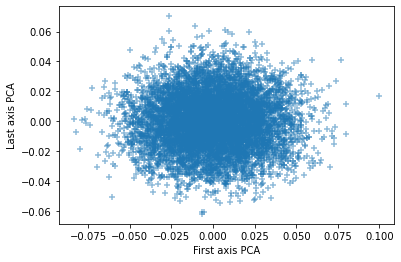

In [62]:
pca = PCA()
theta_pca = pca.fit_transform(theta)
plt.scatter(theta_pca[:, 0], theta_pca[:, -1], alpha=0.5, marker='+')
plt.xlabel('First axis PCA')
plt.ylabel('Last axis PCA')
plt.show()

## SGD pas constant

On calcul les gradients suivant $\alpha, \beta, \log(\sigma)$, la loss étant:

$-\log(p(y|\theta)) + \frac{1}{N}\log(p(\theta)) = -\log(\mathcal{N}(\alpha + \beta_0 X_{volatile\_acidity} + \beta_1 X_{alcohol}, e^{2*\log(\sigma)}) + \frac{1}{N}(\log(\mathcal{N}(0, 1)) + \log(\mathcal{N}(0, 1)) + \log(\mathcal{N}(0, 1)))$ 


Avec: $p(\theta) = p(\alpha)p(\beta)p(\sigma)$

In [37]:
def grad_loss_torch(alpha, beta, log_sigma, x_, y_, N):

    θ = torch.tensor(np.array([alpha, beta[0], beta[1], log_sigma]), requires_grad=True)
    
    x_, y_, cst = torch.tensor(x_), torch.tensor(y_), torch.tensor(np.log(2*np.pi))
    
    f1 = 0.5*torch.exp(-2*θ[-1]) * (torch.dot(θ[1:-1], x_) + θ[0] - y_)**2 + θ[-1] + 0.5*cst
    f2 = (-1/(2*N))*(θ[0]**2 + torch.dot(θ[1:-1], θ[1:-1]) + θ[-1]**2 + 4*cst)
    
    z = f1 + f2
    
    z.backward()
    grad = θ.grad.numpy()
    
    return grad[0], grad[1:-1], grad[-1]

In [10]:
def grad_loss(alpha, beta, log_sigma, x, y, N):
    
    g_alpha = np.exp(-2*log_sigma)*(np.dot(beta, x) + alpha - y) - alpha/N
    
    g_beta = np.exp(-2*log_sigma)*np.dot(x, np.dot(beta, x) + alpha - y) - beta/N
    
    g_log_sigma = -np.exp(-2*log_sigma)*(np.dot(beta,x) + alpha - y)**2 - log_sigma/N
    
    return g_alpha, g_beta, g_log_sigma

In [42]:
def sgd(lr, X, y, max_iter=1000):
    N = len(y)
    theta_sg = np.zeros((max_iter, 4))
    theta_sg[0] = np.random.normal(size=4)
    for k in tqdm(range(1, max_iter)):
        
        alpha, beta, log_sigma = theta_sg[k-1, 0], theta_sg[k-1, 1:3], theta_sg[k-1, -1]
        S = np.random.randint(N, size=np.random.randint(1, N+1), dtype=int)
        
        tmp_alpha, tmp_g_beta, tmp_g_log_sigma = 0, 0, 0
        
        for index in S:
            x_, y_ = X[index], y[index]
            g_alpha, g_beta, g_log_sigma = grad_loss_torch(alpha, beta, log_sigma, x_, y_, N)
            
            tmp_alpha += g_alpha
            tmp_g_beta += g_beta
            tmp_g_log_sigma += g_log_sigma
            
        theta_sg[k, 0] = alpha - lr*tmp_alpha
        theta_sg[k, 1:3] = beta - lr*tmp_g_beta
        theta_sg[k, -1] = log_sigma - lr*tmp_g_log_sigma
        
    return theta_sg

On a $\frac{\epsilon^*}{S} = \frac{2D}{NTr(BB^T)}$, ici on a $D=4$ et on prend $BB^T=I_D$, la mise à jour de la SGD est donc:

$$ \theta(t+1) = \theta(t) - \frac{\epsilon^*}{S} \sum \limits_{i \in \mathcal{S}}-\log(p(y_i|\theta(t))) + \frac{1}{N}\log(p(\theta(t)))$$

In [43]:
lr = (2*4)/(4*len(y))
max_iter = 2000
theta_sgd = sgd(lr, X, y, max_iter)

100%|█████████████████████████████████████████████████████████████████████████████| 1999/1999 [07:14<00:00,  4.60it/s]


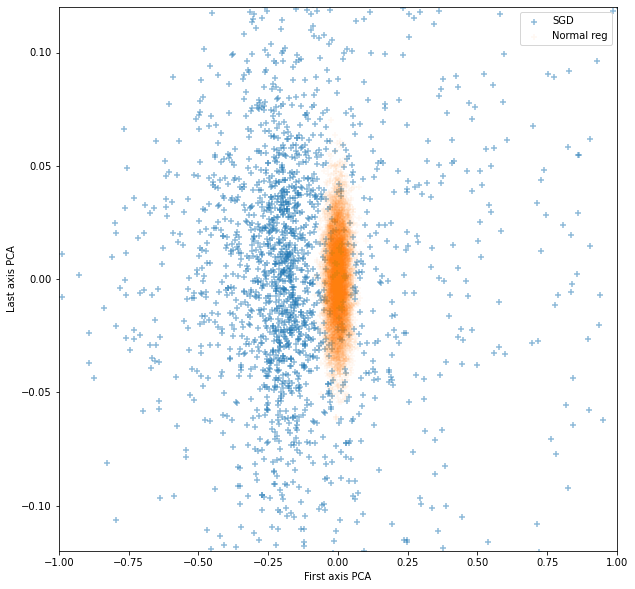

In [68]:
plt.figure(figsize=(10, 10))
plt.scatter(theta_pca_sgd[:, 0], theta_pca_sgd[:, -1], alpha=0.5, marker='+', label='SGD')
plt.scatter(theta_pca[:, 0], theta_pca[:, -1], alpha=0.05, marker='+', label='Normal reg')
plt.margins(x=0.1, y=0.001)
plt.xlabel('First axis PCA')
plt.ylabel('Last axis PCA')
plt.legend(loc='best')
plt.axis([-1, 1, -0.12, 0.12])
plt.show()